In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../lib/PythonGbinReader/GbinReader/'))
import gbin_reader

In [3]:
from astropy.io import fits
import astroscrappy
from matplotlib.colors import LogNorm
import scipy.ndimage as ndimage

In [135]:
# Read in a BamObservation gbin file
#data_file='../../datasets/gbins/bam/07-2017/BamObservation_000-000-007.gbin'
data_file='../../datasets/gbins/bam/09-2017/BamObservation_000-000-019.gbin' # this one is from the flare

reader = gbin_reader.GbinReader(data_file)
bamObs = reader.__next__()

In [199]:
print("")
print("BAM AC Coordinate   : %s" % bamObs.ac)   
print("BAM Acquistion Time : %s" % bamObs.acqTime)
print("BAM Acquistion Row  : %s" % bamObs.ccdRow)
print("BAM Number of Packet: %s" % bamObs.numPackets)
print("BAM Obs. SolutionId : %s" % bamObs.solutionId)
print("BAM Nb. of  Samples : %s" % len(bamObs.samples))
print("")
print(" --> Each BAM TM Packet is transformed into one BamObservation object.")
print(" --> Each BamObservation contain 2 BAM patterns.")
print(" --> A BAM pattern is 500 (Along Scan - AL) x 80 (Across Scan - AC) samples = 40000.")
print("")


BAM AC Coordinate   : 473
BAM Acquistion Time : 122138460342363500
BAM Acquistion Row  : 1
BAM Number of Packet: 2
BAM Obs. SolutionId : 3158430714784907264
BAM Nb. of  Samples : 80000

 --> Each BAM TM Packet is transformed into one BamObservation object.
 --> Each BamObservation contain 2 BAM patterns.
 --> A BAM pattern is 500 (Along Scan - AL) x 80 (Across Scan - AC) samples = 40000.



In [200]:
pattern1 = np.array(bamObs.samples[:40000]).reshape((500,80))
pattern2 = np.array(bamObs.samples[40000:]).reshape((500,80))

Let's look at one of the patterns:

In [201]:
source = pattern1

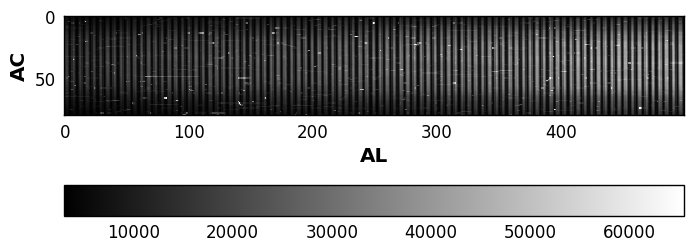

In [202]:
image=np.rot90(source,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)

Let's extract some cosmics

In [203]:
gain=3.853           # gain [e-/ADU]
rn=8.365785291814616 # readout noise [e-]
bias=2576.000        # bias [ADU]

# bias subtraction
source = source - bias

# already use gain
source = source * gain

In [204]:
# using default values
(mask,clean) = astroscrappy.detect_cosmics((source), gain=1, verbose=True, sigclip=4.5, objlim=5,
                                           inmask=None, satlevel=65535, readnoise=rn, sepmed=False,
                                           cleantype='medmask', fsmode='median',niter=4)

Starting 4 L.A.Cosmic iterations
Iteration 1:
918 cosmic pixels this iteration
Iteration 2:
1037 cosmic pixels this iteration
Iteration 3:
953 cosmic pixels this iteration
Iteration 4:
876 cosmic pixels this iteration


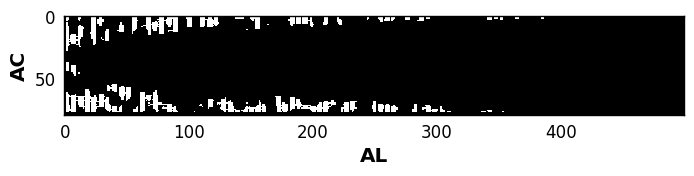

In [205]:
image=np.rot90(mask,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

Interestingly enough, it detects the fringes at their edges in AC...

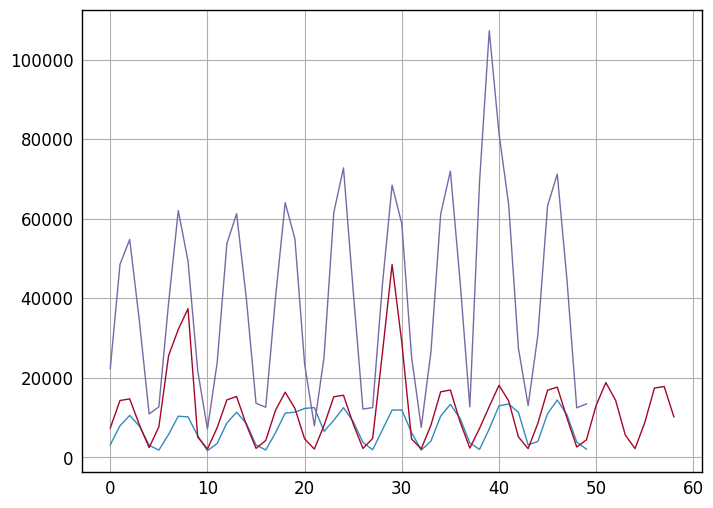

In [206]:
plt.plot(source[:50,0])
plt.plot(source[:50,40])
plt.plot(source[:59,79])

Yes, the BAM patterns are most likely too sharp. We need to get around this somehow.

Let's see what the individual components of astroscrappy do

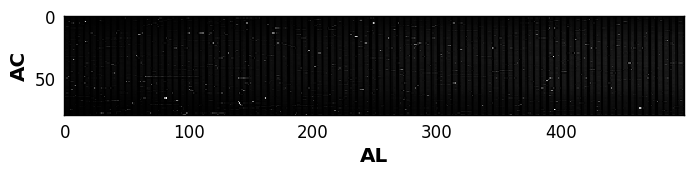

In [207]:
# Laplacian filter

lp = astroscrappy.subsample((source).astype("float32"))
lp = astroscrappy.laplaceconvolve(lp)
lp [lp<0] = 0      # clipping
lp = astroscrappy.rebin(lp)

image=np.rot90(lp,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

The edge detection sees the bam fringes, but nicely highlights some cosmics.

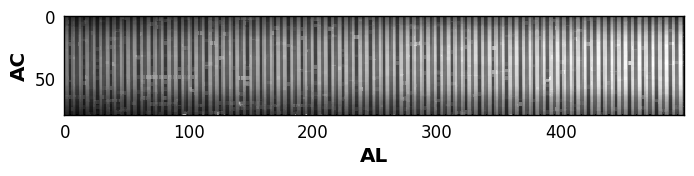

In [208]:
# Noise map

#m5 = astroscrappy.medfilt5((source).astype("float32"))
#m5[m5 < 0.00001] = 0.00001    # clipping
#noise = np.sqrt(m5 + rn*rn)

# try this using a 3x3 median filter - this should better sample the pattern 
# (but be more susceptible) to local variations...
m3 = astroscrappy.medfilt3((source).astype("float32"))
m3[m3 < 0.00001] = 0.00001    # clipping
noise = np.sqrt(m3 + rn*rn)

image=np.rot90(noise,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

The noise image is assumed to be Poisson + readnoise here. This is why it sees the pattern.

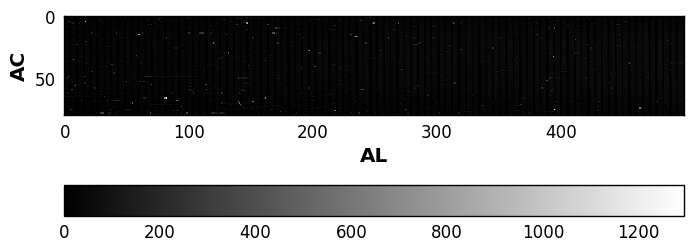

In [209]:
# weigh by noise

S = lp/2/noise

image=np.rot90(S,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)

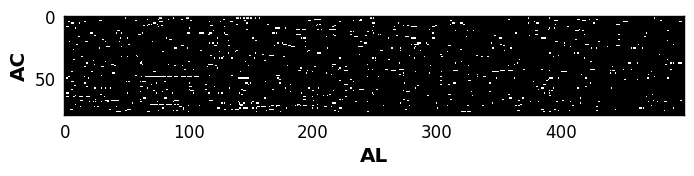

In [210]:
# remove sampling flux - this is now the first criterion

Sp = S - astroscrappy.medfilt5(S)
#Sp = S - astroscrappy.medfilt3(S)

stest = np.copy(Sp)
sigclip = 30

stest[Sp<sigclip] = 0
stest[Sp>=sigclip] = 1


image=np.rot90(stest,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

Well, this actually looks good so far - if I increse sigclip to 30, that is. We should play around later.

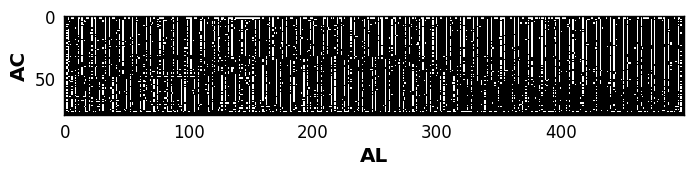

In [211]:
# fine structure image

f = astroscrappy.medfilt3((source).astype("float32"))
f = (f - astroscrappy.medfilt7(f)) / noise
f[f < 0.01] = 0.01     # clipping

objlim = 5
ftest = Sp / f         # the second criterion

ftest[(Sp / f)<objlim]=0
ftest[(Sp / f)>=objlim]=1


image=np.rot90(ftest,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

Well, there's your problem. Even setting this to 1000 shows weird features

Let's try to work off Sp to construct my own cosmic mask. First do the more relaxed neighbour treatment:

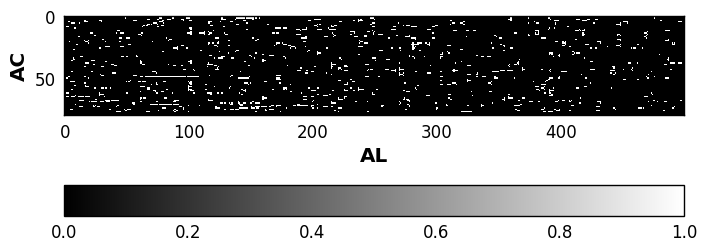

In [212]:
mask=(np.copy(stest)).astype('bool')

mask = astroscrappy.dilate3(mask)
mask = np.logical_and(Sp > sigclip, mask)

mask = astroscrappy.dilate3(mask)
mask = np.logical_and(Sp > 0.3*sigclip, mask)

image=np.rot90(mask,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)

Looking at this, it seems like several of the "long" streaks in AL are getting chopped up by the fringe. We may have to find some way to remove it after all...

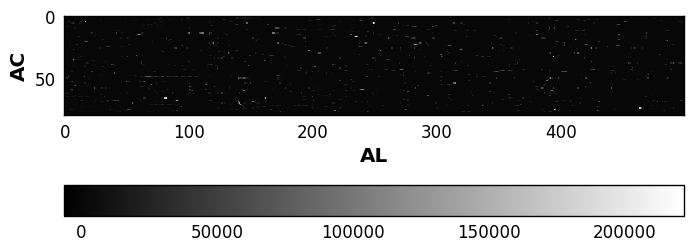

In [213]:
#cosmics=(source-m5)*mask  # we may need to improve background subtraction via better knowledge of the pattern
cosmics=(source-m3)*mask
image=np.rot90(cosmics,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [214]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask,structure=(np.ones((3,3))))
#(labels, ntracks) = ndimage.measurements.label(mask,structure=[[0,1,0],[1,1,1],[0,1,0]])
#(labels, ntracks) = ndimage.measurements.label(dilmask,structure=[[0,1,0],[1,1,1],[0,1,0]])

# object extraction based on labels
events = ndimage.measurements.find_objects(labels)

print("Number of events:", ntracks)

Number of events: 586


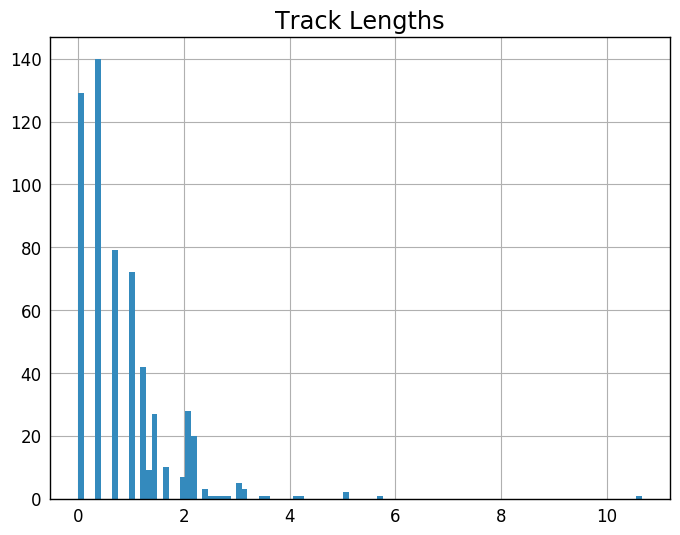

In [215]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)

for ii in range(ntracks):
    dx = (events[ii][0].stop-events[ii][0].start-1)/3. # to roughly account for the binning. Unit would be AC-Pixels
    dy = events[ii][1].stop-events[ii][1].start-1       # need to subtract 1, since single pixel cosmics would then have
                                                        # a length of sqrt(2)
    lengths[ii] = np.sqrt(dx**2 + dy**2)

lhist = plt.hist(lengths,100)
plt.title("Track Lengths")

In [216]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[events[ii]])

Min: 524.00896875
Max: 1109552.2813


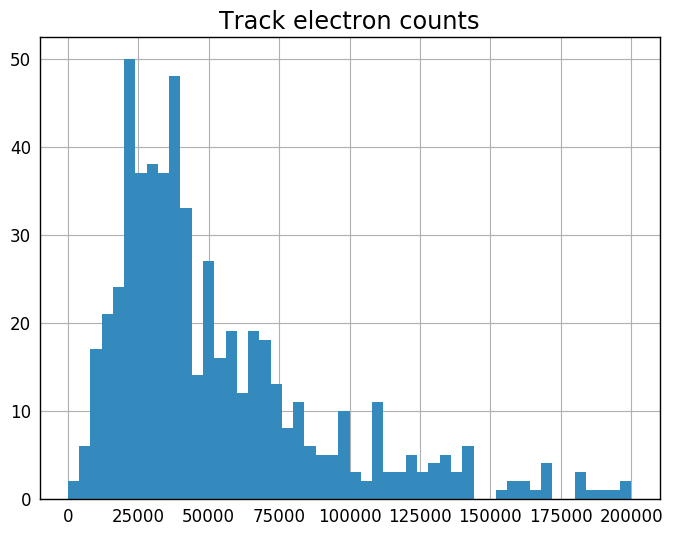

In [217]:
#ehist = plt.hist(events_e,100)
ehist = plt.hist(events_e,50,range=(0,200000)) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

During the flare, the shape of the histogram looks good, but we are at much higher energies. Would this be expected?

I probably also messed up the background subtraction - note the minimum value being negative. Right now we subtract a 5x5 median filter of the source image, which is as broad or broader than a BAM fringe.

A 3x3 median filter at least no longer gives negative values - perhaps because it better accounts for the local variations.